In [1]:
from panel_segmentation import utils
import glob
import matplotlib.pyplot as plt
from PIL import Image
import os
import pandas as pd
import folium
import torch
from mmengine import Config
from mmdet.apis import init_detector, inference_detector
from mmdet.registry import VISUALIZERS
import mmcv
import numpy as np
import geopandas
from shapely.ops import unary_union
from shapely.geometry import Polygon, mapping
import shapely
import matplotlib.colors as mcolors

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


C:\Users\kperry\AppData\Roaming\Python\Python311\site-packages\mmengine\optim\optimizer\zero_optimizer.py:11: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import \


# Automatically Geotag a Fixed Tilt Utility PV Site

The following example uses Panel-Segmentation's automated geotagging pipeline to isolate all the trackers rows and inverters on a utility PV site. This data is then aggregated to create master geoJSON file for the site. The PV site used in this example is available from the American-Made Solar Data Bounty Prize (https://www.energy.gov/eere/solar/american-made-solar-data-bounty-prize). Site metadata and performance data is available via the Open Energy Data Initiative (OEDI), under system ID 2107 (https://data.openei.org/submissions/4568).

In [2]:
sys_latitude, sys_longitude = 38.996306,-122.134111
# Set northwest and southeast bounding lat-longitude coordinates to 
# take all of the satellite images of the site
northwest_lat, northwest_lon =   38.996910, -122.135456
southeast_lat, southeast_lon =   38.995338, -122.133898
google_maps_api_key = "YOUR_API_KEY_HERE"
zoom_level = 20
file_save_folder = "../../../panel_segmentation/examples/automated-geotagging_data_examples_fixed_tilt"
grid_info_list = utils.generateSatelliteImageryGrid(northwest_lat, northwest_lon,
                                                    southeast_lat, southeast_lon,
                                                    google_maps_api_key,
                                                    file_save_folder,
                                                    zoom_level,
                                                    lat_lon_distance=.00064)

File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!
File already pulled!


Visualize the data set in grid format.

38.99691_-122.135456.png
38.99627_-122.135456.png
38.99563_-122.135456.png
38.99499_-122.135456.png
38.99691_-122.134816.png
38.99627_-122.134816.png
38.99563_-122.134816.png
38.99499_-122.134816.png
38.99691_-122.134176.png
38.99627_-122.134176.png
38.99563_-122.134176.png
38.99499_-122.134176.png
38.99691_-122.133536.png
38.99627_-122.133536.png
38.99563_-122.133536.png
38.99499_-122.133536.png


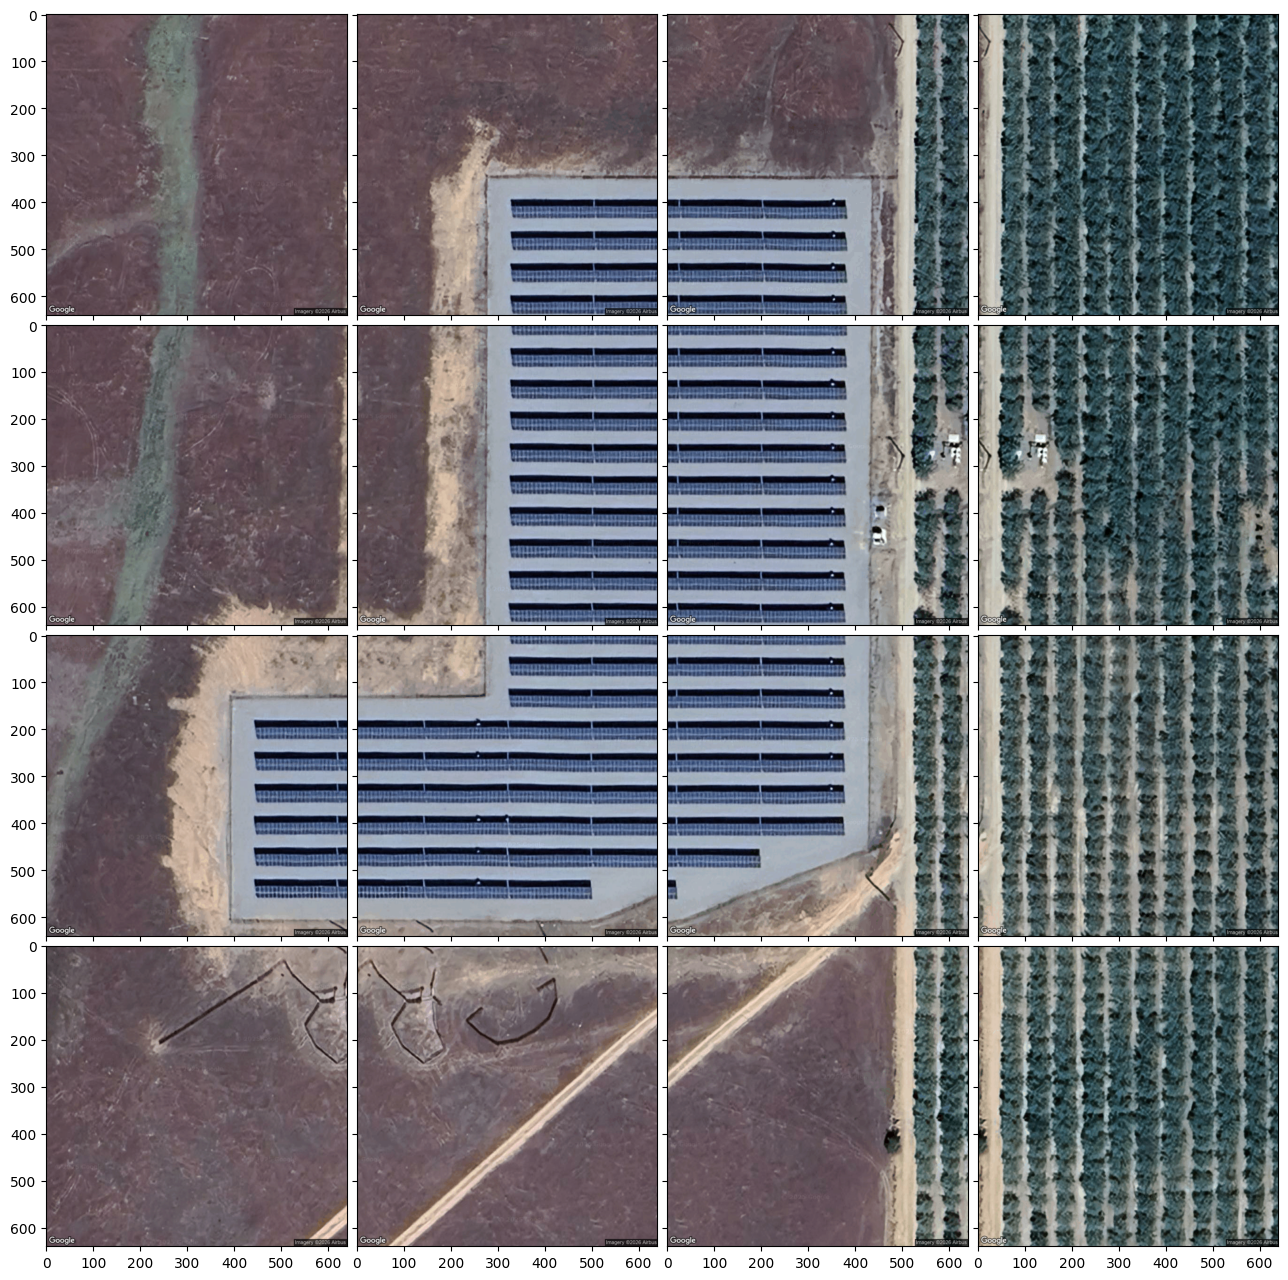

In [3]:
plot = utils.visualizeSatelliteImageryGrid(grid_info_list, file_save_folder)
plt.show()

Load in the automated geotagging CV algorithm. All images will be run through it to identify site equipment.

In [4]:
cfg = Config.fromfile("../../../panel_segmentation/models/automated_geotagging_config.py")
checkpoint_file = "../../../panel_segmentation/models/automated_geotagging_model.pth"
model = init_detector(cfg, device='cpu')
checkpoint = torch.load(checkpoint_file, map_location='cpu', weights_only=False)
model.load_state_dict(checkpoint['state_dict'])
visualizer = VISUALIZERS.build(model.cfg.visualizer)

# Run inference on the example images
inference_data_list = list()
results = list()
grid_files = glob.glob(os.path.join(file_save_folder, "*.png"))
for i, file in enumerate(grid_files):
    img = mmcv.imread(file, channel_order='rgb')
    new_result = inference_detector(model, img)
    new_result.file = file
    results.append(new_result)

c:\users\kperry\documents\source\repos\mmdetection\mmdet\apis\inference.py:70: UserWarning: checkpoint is None, use COCO classes by default.
  warnings.warn('checkpoint is None, use COCO classes by default.')
c:\users\kperry\documents\source\repos\mmdetection\mmdet\models\layers\se_layer.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
c:\users\kperry\documents\source\repos\mmdetection\mmdet\models\backbones\csp_darknet.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
C:\Users\kperry\.conda\envs\deep-learning\Lib\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\T

Convert all the masks to geoJSON's and merge them into a master geoJSON file.

In [5]:
inference_data_list = list()
system_boundary_poly = Polygon([(northwest_lon, northwest_lat),
                                (southeast_lon, northwest_lat),
                                (southeast_lon, southeast_lat),
                                (northwest_lon, southeast_lat)])
for result in results:
    predictions = result._pred_instances
    masks = predictions.masks
    labels = predictions.labels
    scores = predictions.scores
    # Take all labels meeting a 0.3 threshold or greater
    idx_to_keep = np.argwhere(scores>=0.35).tolist()[0]
    file_name = os.path.basename(result.file)
    img_center_lat, img_center_lon = float(file_name.split("_")[0]), float(file_name.split("_")[-1].replace(".png", ""))
    image_x_pixels, image_y_pixels = new_result.img_shape
    # Convert all of the masks to latitude-longitude-based polygons
    for index in range(len(masks)):
            if index in idx_to_keep:
                segmentation_mask = masks[index].data.cpu().numpy()
                # Convert the mask to a polygon
                polygon_lat_lon_coords = utils.convertMaskToLatLonPolygon(segmentation_mask, 
                                                                    img_center_lat, 
                                                                    img_center_lon,
                                                                    image_x_pixels, 
                                                                    image_y_pixels,
                                                                    zoom_level=20)
                # Convert to a geoJSON
                shapely_poly = Polygon(polygon_lat_lon_coords)
                if not shapely.is_valid(shapely_poly):
                    shapely_poly =shapely.make_valid(shapely_poly)
                # Check if the polygon is entirely within the system bounds. If not, don't record it. This is an extra cleaning
                # precaution
                if not shapely_poly.intersects(system_boundary_poly):
                    continue
                else:
                    geojson_poly = geopandas.GeoSeries(shapely_poly).to_json()
                    inference_data_list.append({"image": result.file,
                                                "poly": shapely_poly,
                                                "label": int(labels[index])})
inference_df = pd.DataFrame(inference_data_list)

Fuse features of the same mask type.

In [6]:
labels = list(inference_df['label'].drop_duplicates())
label_dictionary = {0: "inverter", 
                    1: "dual-axis-tracker-row",
                    2: "fixed-tilt-row",
                    3: "single-axis-tracker-row"}

# Create a color map for the different labels
colors = plt.cm.tab10(range(len(labels)))  # or try tab20, Set3, Paired
color_map = {label_dictionary[label]: mcolors.rgb2hex(colors[i]) for i, label in enumerate(labels)}

merged_features = list()
for label in labels:
    inference_label_subset = inference_df[inference_df['label'] == label]
    polygons = list(inference_label_subset['poly'])
    print(label)
    # Run a union for the labels to fuse them all together
    unioned = unary_union(polygons)
    if unioned.geom_type == "Polygon":
        merged_features.append({
                "type": "Feature",
                "properties": {"class": label_dictionary[label]},
                "geometry": mapping(unioned)
            })
    else:
        for poly in unioned.geoms:
            merged_features.append({
                    "type": "Feature",
                    "properties": {"class": label_dictionary[label]},
                    "geometry": mapping(poly)
                })
geojson = {"type": "FeatureCollection", "features": merged_features}

2
0


In [10]:
import json
pretty_output = json.dumps(geojson, indent=2, sort_keys=True)
print(pretty_output)

{
  "features": [
    {
      "geometry": {
        "coordinates": [
          [
            [
              -122.13503029146739,
              38.99540842728223
            ],
            [
              -122.13503029072415,
              38.995408426702234
            ],
            [
              -122.13502875638692,
              38.995408426696784
            ],
            [
              -122.1350287563932,
              38.995407382131525
            ],
            [
              -122.13492180641046,
              38.99540738227761
            ],
            [
              -122.13492046708728,
              38.99540633712539
            ],
            [
              -122.13468474648009,
              38.99540633709833
            ],
            [
              -122.13468340716042,
              38.995405291943406
            ],
            [
              -122.13459233329078,
              38.99540529180437
            ],
            [
              -122.13459099396587,
   

Show the final mapped geoJSON data.

In [7]:
 m = folium.Map(location=[sys_latitude, sys_longitude],
                zoom_start=18,
                tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
                attr = 'Esri',
                name = 'Esri Satellite')

folium.GeoJson(
        geojson,
        style_function=lambda feature: {
            'fillColor': color_map[feature['properties']['class']],
            'color': color_map[feature['properties']['class']],  # border color
            'weight': 2,
            'fillOpacity': 0.6,
        },
        tooltip=folium.GeoJsonTooltip(fields=['class'], aliases=['Label:'])
    ).add_to(m)
m